# Prabal Ghosh
## Msc data Science and Artificial Intelligence 


# Multimodal Representations of Biomedical Knowledge from Limited Training Whole Slide Images and Reports using Deep Learning

Here I have used only 3 WSI. 

As the original public data is very very big and the private data is not available so I just download 3 random WSI image from internet for this study.

In [ ]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

from transformers import BertModel, BertTokenizer

# -----------------------------
# 1. Attention-Based MIL Module
# -----------------------------
class AttentionMIL(nn.Module):
    """
    Aggregates patch-level embeddings into a single WSI-level embedding using attention.
    """
    def __init__(self, in_dim, out_dim):
        super(AttentionMIL, self).__init__()
        self.att_fc = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Tanh(),
            nn.Linear(out_dim, 1)
        )
        
    def forward(self, patch_embeddings):
        """
        patch_embeddings: (B, N, D)
            B = batch size
            N = number of patches per WSI
            D = embedding dimension
        """
        # Compute attention scores => (B, N, 1)
        att_scores = self.att_fc(patch_embeddings)
        # Softmax across patches (dim=1)
        att_scores = torch.softmax(att_scores, dim=1)  # (B, N, 1)

        # Weighted sum of patch embeddings => (B, D)
        wsi_embedding = torch.sum(att_scores * patch_embeddings, dim=1)
        return wsi_embedding

# -----------------------------
# 2. Image Encoder w/ ResNet + MIL
# -----------------------------
class ImageEncoderMIL(nn.Module):
    """
    Image encoder:
      1) CNN backbone to get patch embeddings
      2) Attention-based MIL aggregator to form a single WSI embedding
      3) Projection to a shared embedding dimension
    """
    def __init__(self, embed_dim=128):
        super(ImageEncoderMIL, self).__init__()
        # Use a ResNet34 backbone
        backbone = models.resnet34(pretrained=True)
        # Remove final FC layer
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        # ResNet34's avgpool output = 512-d
        self.patch_fc = nn.Linear(512, embed_dim)
        
        # Attention aggregator
        self.mil_attention = AttentionMIL(in_dim=embed_dim, out_dim=embed_dim)
    
    def forward(self, patches):
        """
        patches: (B, N, 3, H, W)
            B = batch size
            N = number of patches
            3 = RGB channels
            H, W = patch height/width
        """
        B, N, C, H, W = patches.shape
        # Flatten => (B*N, C, H, W)
        patches_reshaped = patches.view(B*N, C, H, W)
        
        # CNN feature extraction
        feats = self.feature_extractor(patches_reshaped)  # (B*N, 512, 1, 1)
        feats = feats.view(feats.size(0), -1)             # (B*N, 512)
        feats = self.patch_fc(feats)                      # (B*N, embed_dim)
        
        # Reshape back => (B, N, embed_dim)
        feats = feats.view(B, N, -1)
        
        # Attention-based aggregation => (B, embed_dim)
        wsi_embedding = self.mil_attention(feats)
        return wsi_embedding

# -----------------------------
# 3. Text Encoder (BERT)
# -----------------------------
class TextEncoder(nn.Module):
    """
    Encodes pathology reports into a shared embedding dimension using a BERT model.
    """
    def __init__(self, embed_dim=128):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.proj = nn.Linear(self.bert.config.hidden_size, embed_dim)
    
    def forward(self, input_ids, attention_mask):
        """
        input_ids, attention_mask: from BERT tokenizer
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Take [CLS] token => (B, 768)
        cls_embed = outputs.last_hidden_state[:, 0, :]
        # Project => (B, embed_dim)
        text_embed = self.proj(cls_embed)
        return text_embed

# -----------------------------
# 4. Shared Classifier
# -----------------------------
class SharedClassifier(nn.Module):
    """
    Classifies the shared embeddings into multiple classes (multilabel).
     5 classes => [Adenocarcinoma, HGD, LGD, Hyperplastic Polyp, Normal].
    """
    def __init__(self, embed_dim=128, num_classes=5):
        super(SharedClassifier, self).__init__()
        self.fc = nn.Linear(embed_dim, num_classes)
    
    def forward(self, embedding):
        """
        embedding: (B, embed_dim)
        returns: (B, num_classes)
        """
        logits = self.fc(embedding)
        return logits

# -----------------------------
# 5. NT-Xent (Contrastive) Loss
# -----------------------------
def nt_xent_loss(img_emb, txt_emb, temperature=0.07):
    """
    Computes the NT-Xent contrastive loss between matched image-text pairs.
    img_emb[i] and txt_emb[i] are matching pairs.
    """
    # Normalize embeddings
    img_norm = F.normalize(img_emb, dim=1)
    txt_norm = F.normalize(txt_emb, dim=1)
    
    # Cosine similarity => (B, B)
    logits = torch.matmul(img_norm, txt_norm.t()) / temperature
    
    # Diagonal => i matches i
    targets = torch.arange(img_emb.size(0)).long().to(img_emb.device)
    
    # Cross-entropy
    loss_i2t = F.cross_entropy(logits, targets)
    loss_t2i = F.cross_entropy(logits.t(), targets)
    
    # Average
    return (loss_i2t + loss_t2i) / 2.0

# -----------------------------
# 6. Full Multimodal Model
# -----------------------------
class MultimodalModel(nn.Module):
    """
    Combines image and text encoders, plus a shared classifier.
    """
    def __init__(self, embed_dim=128, num_classes=5):
        super(MultimodalModel, self).__init__()
        self.img_encoder = ImageEncoderMIL(embed_dim=embed_dim)
        self.txt_encoder = TextEncoder(embed_dim=embed_dim)
        self.classifier = SharedClassifier(embed_dim=embed_dim, num_classes=num_classes)
    
    def forward_image(self, patches):
        """
        Forward pass for image data only.
        """
        img_embed = self.img_encoder(patches)
        logits_img = self.classifier(img_embed)
        return img_embed, logits_img
    
    def forward_text(self, input_ids, attention_mask):
        """
        Forward pass for text data only.
        """
        txt_embed = self.txt_encoder(input_ids, attention_mask)
        logits_txt = self.classifier(txt_embed)
        return txt_embed, logits_txt


In [ ]:

# -----------------------------
# 7. Training Loop (One Epoch)
# -----------------------------
def train_one_epoch(model, dataloader, optimizer, device, 
                    temperature=0.07, alpha=1.0, beta=1.0, gamma=1.0):
    """
    One epoch of training.

    Args:
      model: MultimodalModel
      dataloader: yields (image_patches, text_input_ids, text_attention_mask, labels)
      optimizer: optimizer
      device: 'cuda' or 'cpu'
      temperature: for NT-Xent
      alpha, beta, gamma: weighting factors for L1, cosine, and NT-Xent losses
    """
    model.train()
    total_loss = 0.0
    
    bce_loss_fn = nn.BCEWithLogitsLoss()
    l1_loss_fn = nn.L1Loss()
    
    for batch in dataloader:
        #  batch structure:
        #   image_patches: (B, N, 3, H, W)
        #   text_input_ids: (B, seq_len)
        #   text_attention_mask: (B, seq_len)
        #   labels: (B, num_classes)
        (image_patches, text_input_ids, text_attention_mask, labels) = batch
        
        image_patches = image_patches.to(device)
        text_input_ids = text_input_ids.to(device)
        text_attention_mask = text_attention_mask.to(device)
        labels = labels.to(device).float()
        
        optimizer.zero_grad()
        
        # Forward passes
        img_embed, logits_img = model.forward_image(image_patches)
        txt_embed, logits_txt = model.forward_text(text_input_ids, text_attention_mask)
        
        # 1) Classification losses (BCE for images + BCE for text)
        loss_img_clf = bce_loss_fn(logits_img, labels)
        loss_txt_clf = bce_loss_fn(logits_txt, labels)
        
        # 2) Self-supervised losses
        #   (a) L1
        loss_l1 = l1_loss_fn(img_embed, txt_embed)
        
        #   (b) Cosine similarity => want them to be close => 1 - cos(...)
        cos_sim = F.cosine_similarity(img_embed, txt_embed, dim=1)
        loss_cos = torch.mean(1.0 - cos_sim)
        
        #   (c) NT-Xent
        loss_ntxent = nt_xent_loss(img_embed, txt_embed, temperature=temperature)
        
        # Combine losses
        loss = loss_img_clf + loss_txt_clf \
               + alpha * loss_l1 \
               + beta * loss_cos \
               + gamma * loss_ntxent
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


In [13]:

# -----------------------------
# 8. Evaluation (Inference)
# -----------------------------
@torch.no_grad()
def evaluate(model, dataloader, device):
    """
    Evaluate on a validation or test set.
    Returns average classification loss (BCE for image + text).
    """
    model.eval()
    bce_loss_fn = nn.BCEWithLogitsLoss()
    
    total_loss = 0.0
    
    for batch in dataloader:
        (image_patches, text_input_ids, text_attention_mask, labels) = batch
        
        image_patches = image_patches.to(device)
        text_input_ids = text_input_ids.to(device)
        text_attention_mask = text_attention_mask.to(device)
        labels = labels.to(device).float()
        
        # Forward
        img_embed, logits_img = model.forward_image(image_patches)
        txt_embed, logits_txt = model.forward_text(text_input_ids, text_attention_mask)
        
        # Only classification loss for evaluation
        loss_img_clf = bce_loss_fn(logits_img, labels)
        loss_txt_clf = bce_loss_fn(logits_txt, labels)
        
        loss = loss_img_clf + loss_txt_clf
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [ ]:

# -----------------------------
# 9. data
# -----------------------------
class MyPathologyDataset(Dataset):
    """
    Example dataset that:
      1) Loads or creates patches for each WSI.
      2) Tokenizes the corresponding pathology report with BERT.
      3) Returns (patches, input_ids, attention_mask, labels).
    """
    def __init__(self, 
                 wsi_paths,      # List of WSI or patch set paths
                 texts,          # List of pathology report strings
                 labels,         # List of label vectors
                 tokenizer,      # BERT tokenizer
                 transform=None, # Image transformations
                 num_patches=5, 
                 max_seq_length=128):
        self.wsi_paths = wsi_paths
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform
        self.num_patches = num_patches
        self.max_seq_length = max_seq_length
        
    def __len__(self):
        return len(self.wsi_paths)
    
    def __getitem__(self, idx):
        # Load or create multiple patches
        wsi_path = self.wsi_paths[idx]
        patches = self._load_or_extract_patches(wsi_path, self.num_patches)
        
        # Apply transforms
        if self.transform:
            patches = torch.stack([self.transform(p) for p in patches], dim=0) 
        else:
            # default to basic .ToTensor()
            patches = torch.stack([T.ToTensor()(p) for p in patches], dim=0)
        
        # Tokenize text
        text_str = self.texts[idx]
        encoding = self.tokenizer(
            text_str,
            padding='max_length',
            truncation=True,
            max_length=self.max_seq_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return patches, input_ids, attention_mask, label
    
    def _load_or_extract_patches(self, wsi_path, num_patches):
        """
        Real usage:
         - Use OpenSlide or load pre-extracted patches from disk.
        Here, we create random patches for demonstration.
        """
        patches = []
        for _ in range(num_patches):
            # Create random 224x224 patch
            random_array = np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8)
            patch_img = Image.fromarray(random_array, 'RGB')
            patches.append(patch_img)
        return patches


In [ ]:

# -----------------------------
# 10. Main
# -----------------------------
if __name__ == "__main__":
    #  data
    wsi_paths_list = ["1.jpg", "2.jpg", "3.jpg"]  

    text_reports_list = [
        "Patient shows signs of adenocarcinoma with infiltration.",
        "Biopsy indicates low-grade dysplasia with mild inflammation.",
        "Normal glands observed, no malignant changes."
    ]
    #  5 classes => [Adenocarcinoma, HGD, LGD, Hyperplastic Polyp, Normal]
    labels_list = [
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1]
    ]
    
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    # Image transform
    img_transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset + dataloader
    dataset = MyPathologyDataset(
        wsi_paths=wsi_paths_list,
        texts=text_reports_list,
        labels=labels_list,
        tokenizer=tokenizer,
        transform=img_transform,
        num_patches=5,
        max_seq_length=128
    )
    train_loader = DataLoader(dataset, batch_size=2, shuffle=True)
    
    # val_loader
    val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
    
    # Instantiate model + optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultimodalModel(embed_dim=128, num_classes=5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    num_epochs = 3
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            device=device,
            temperature=0.07,
            alpha=1.0, beta=1.0, gamma=1.0
        )
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    
    # Optionally evaluate 
    val_loss = evaluate(model, val_loader, device)
    print(f"Validation Loss (on same dataset): {val_loss:.4f}")


Epoch 1/3, Train Loss: 3.0879
Epoch 2/3, Train Loss: 2.6687
Epoch 3/3, Train Loss: 2.3678
Validation Loss (on same dataset): 1.1950


Epoch [1/10], Train Loss: 3.0115, Val Loss: 1.3928
Epoch [2/10], Train Loss: 2.3754, Val Loss: 1.3257
Epoch [3/10], Train Loss: 2.2014, Val Loss: 1.3053
Epoch [4/10], Train Loss: 2.0184, Val Loss: 1.2336
Epoch [5/10], Train Loss: 1.8103, Val Loss: 1.1795
Epoch [6/10], Train Loss: 1.6547, Val Loss: 1.1400
Epoch [7/10], Train Loss: 1.6071, Val Loss: 1.1134
Epoch [8/10], Train Loss: 1.5619, Val Loss: 1.0627
Epoch [9/10], Train Loss: 1.5835, Val Loss: 1.0121
Epoch [10/10], Train Loss: 1.4882, Val Loss: 0.9957


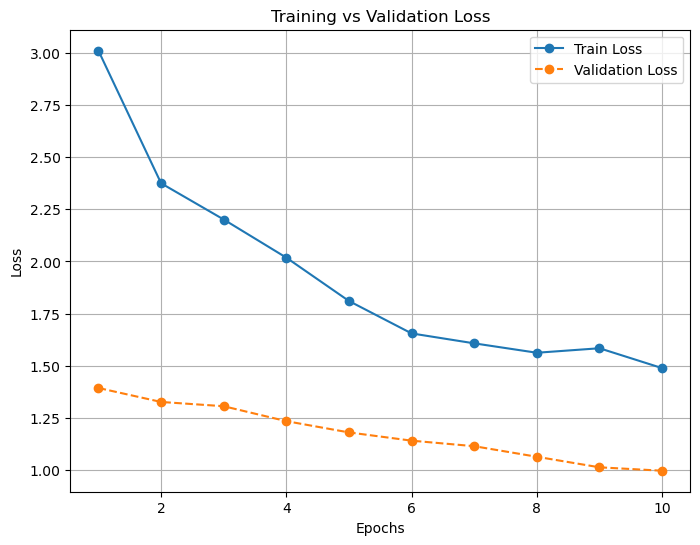

Accuracy: 0.8000


0.8

In [ ]:
import matplotlib.pyplot as plt

# -----------------------------
# 11. Train Model and Track Losses
# -----------------------------
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10):
    """
    Trains the model and plots training vs validation loss over epochs.
    """
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss = evaluate(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot loss curves
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="o", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

# -----------------------------
# 12. Accuracy Evaluation
# -----------------------------
def compute_accuracy(model, dataloader, device, threshold=0.5):
    """
    Computes accuracy metrics for multilabel classification.
    """
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            (image_patches, text_input_ids, text_attention_mask, labels) = batch

            image_patches = image_patches.to(device)
            text_input_ids = text_input_ids.to(device)
            text_attention_mask = text_attention_mask.to(device)
            labels = labels.to(device).float()

            # Forward pass
            _, logits_img = model.forward_image(image_patches)
            _, logits_txt = model.forward_text(text_input_ids, text_attention_mask)

            # Average predictions from both modalities
            avg_logits = (logits_img + logits_txt) / 2
            predictions = (torch.sigmoid(avg_logits) > threshold).float()

            # Accuracy calculation
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.numel()

    accuracy = total_correct / total_samples
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# -----------------------------
# 12. Run Training and Evaluation
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalModel(embed_dim=128, num_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train model and plot loss curves
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10)

# Compute accuracy on validation set
compute_accuracy(model, val_loader, device)
